In this exercise we will sample points from two different two dimensional normal distributions (difference will be in their covariance matrices). We will initially sample 10 point clouds from each distributions. For each point cloud, we will compute its Alpha complex and its persistent homology. The persistence will be stored and subsequently we will try to classify distributions based on their persistence signature. 

In [1]:
import numpy as np
import math
import gudhi as gd
import gudhi.representations
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

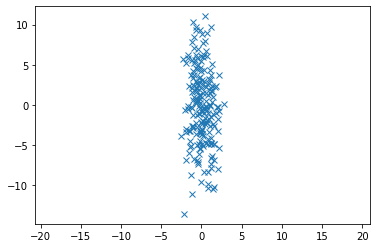

In [2]:
#Here is the first distribution that we will consider
mean_1 = [0, 0]
cov_1 = [[1, 0], [0, 20]]
number_of_points = 200
x, y = np.random.multivariate_normal(mean_1, cov_1, number_of_points).T

#plot it:
plt.plot(x.T, y.T, 'x')
plt.axis('equal')
plt.show()

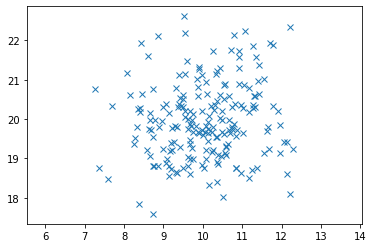

In [3]:
#Here is the second distribution that we will consider
mean_2 = [10, 20]
cov_2 = [[1, 0], [0, 1]]
x2, y2 = np.random.multivariate_normal(mean_2, cov_2, number_of_points).T

#plot it:
plt.plot(x2.T, y2.T, 'x')
plt.axis('equal')
plt.show()

As we can see, those two point clouds are different, and they span different range. Give this, clearly zero dimensional persistet homology will be able to tell them apart. But, since we do not want to make it so easy, we will normalize the point clouds below so that an average distance between a pair of points is 1. In what follows, we will generate ten point clouds from each distribution and compute their persistent homology. 

In [ ]:
#Here we will store diagrams and labels
dgms, labs = [], []
number_of_repetitions_per_class = 10

In [ ]:
#Here we will generate the point cloud again, normalize it, and re-run the persistent homology information:

for cls in range(0,number_of_repetitions_per_class):
    x, y = np.random.multivariate_normal(mean_1, cov_1, number_of_points).T
    
    #Now compute average distance between points 
    sum_ = 0
    count = 0
    for i in range( 0,len(x) ):
        for j in range( i+1,len(y) ):
            #Compute Euclidean distance between (x[i],y[i]) and (x[j],y[j])
            dst = math.sqrt( (x[i]-x[j])**2 + (y[i]-y[j])**2 )
            sum_ = sum_+dst
            count = count+1 
    average_distance = sum_/count;

    #And normalize the point clouds:
    for i in range(0,len(x)):
        x[i] = x[i] / average_distance
    for i in range(0,len(y)):
        y[i] = y[i] / average_distance

    #Prepare points for Gudhi
    pts1 = np.array([x,y]).T
    pts1 = pts1.tolist();

    simplex_tree = gd.AlphaComplex(points=pts1).create_simplex_tree()
    pers = simplex_tree.persistence()
    plt = gd.plot_persistence_diagram( pers )
    dgms.append(simplex_tree.persistence_intervals_in_dimension(1))
    labs.append(1)

In [ ]:
#and now the same for mean_2 and cov_2:
for cls in range(0,number_of_repetitions_per_class):
    x, y = np.random.multivariate_normal(mean_2, cov_2, number_of_points).T
    
    #Now compute average distance between points 
    sum_ = 0
    count = 0
    for i in range( 0,len(x) ):
        for j in range( i+1,len(y) ):
            #Compute Euclidean distance between (x[i],y[i]) and (x[j],y[j])
            dst = math.sqrt( (x[i]-x[j])**2 + (y[i]-y[j])**2 )
            sum_ = sum_+dst
            count = count+1 
    average_distance = sum_/count;

    #And normalize the point clouds:
    for i in range(0,len(x)):
        x[i] = x[i] / average_distance
    for i in range(0,len(y)):
        y[i] = y[i] / average_distance

    #Prepare points for Gudhi
    pts1 = np.array([x,y]).T
    pts1 = pts1.tolist();

    simplex_tree = gd.AlphaComplex(points=pts1).create_simplex_tree()
    pers = simplex_tree.persistence()
    plt = gd.plot_persistence_diagram( pers )
    dgms.append(simplex_tree.persistence_intervals_in_dimension(1))
    labs.append(2)

The following classification code was taken from:
https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-representations.ipynb
by Mathieu Carrière and Vincent Rouvreau. Thank you!

In [ ]:
test_size            = 0.5
perm                 = np.random.permutation(len(labs))
limit                = np.int(test_size * len(labs))
test_sub, train_sub  = perm[:limit], perm[limit:]
train_labs           = np.array(labs)[train_sub]
test_labs            = np.array(labs)[test_sub]
train_dgms           = [dgms[i] for i in train_sub]
test_dgms            = [dgms[i] for i in test_sub]

In [ ]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.pipeline        import Pipeline
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier

# Definition of pipeline
pipe = Pipeline([("Separator", gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
                 ("Scaler",    gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
                 ("TDA",       gd.representations.PersistenceImage()),
                 ("Estimator", SVC())])

# Parameters of pipeline. This is the place where you specify the methods you want to use to handle diagrams
param =    [{"Scaler__use":         [False],
             "TDA":                 [gd.representations.SlicedWassersteinKernel()], 
             "TDA__bandwidth":      [0.1, 1.0],
             "TDA__num_directions": [20],
             "Estimator":           [SVC(kernel="precomputed", gamma="auto")]},
            
            {"Scaler__use":         [False],
             "TDA":                 [gd.representations.PersistenceWeightedGaussianKernel()], 
             "TDA__bandwidth":      [0.1, 0.01],
             "TDA__weight":         [lambda x: np.arctan(x[1]-x[0])], 
             "Estimator":           [SVC(kernel="precomputed", gamma="auto")]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.PersistenceImage()], 
             "TDA__resolution":     [ [5,5], [6,6] ],
             "TDA__bandwidth":      [0.01, 0.1, 1.0, 10.0],
             "Estimator":           [SVC()]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.Landscape()], 
             "TDA__resolution":     [100],
             "Estimator":           [RandomForestClassifier()]},
           
            {"Scaler__use":         [False],
             "TDA":                 [gd.representations.BottleneckDistance()], 
             "TDA__epsilon":        [0.1], 
             "Estimator":           [KNeighborsClassifier(metric="precomputed")]}
           ]

In [ ]:
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(pipe, param, cv=3)
model = model.fit(train_dgms, train_labs)
print(model.best_params_)
print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))